# Predicting Which Bank Customers Will Churn

## Background
When it comes to losing customers, all businesses want to know the reason why each customer made a decision to stop using their product. The same goes for the financial institutes. In this [dataset from Kaggle](https://www.kaggle.com/santoshd3/bank-customers), the data contains numerous factors of each customers as well as whether the customer stayed with the bank. **Using both supervised and unsupervised machine learning techniques, I will make various models that will predict the outcome, and compare each model.**

## Problem Statement
Using the dataset with various features, can I build a machine learning model that will predict whether the customers will stay with the bank?

## Data and Tools Used
I am using a [dataset](https://www.kaggle.com/santoshd3/bank-customers) posted by [Mr. Santosh Kumar](https://www.kaggle.com/santoshd3) on Kaggle. The dataset is in `.csv` format and the dimension is 10,000 rows by 14 columns. Below are the descriptions of each columns:

Columns | Description | Data Type
---: | :--- | :---
RowNumber | Unique row numbers | Integers
CustomerId | Unique customer identification numbers | Integers
Surname | Customer's last name | String
CreditScore | Customer's credit score | Integers
Geography | Customer's residing country | String
Gender | Male or female | String
Age | Customer's age | Integers
Tenure | Number of years the customer used the bank's service | Integers
Balance | Customer's account balance | Float
NumOfProducts | How many banking products does the customer have? | Integers
HasCrCard | 1: has a card with the account, 0: does not have a card | Integers
IsActiveMember | Customer is active with non-banking services such as insurance and investments | Integers
EstimatedSalary | Bank's estimation on the customer's salary | Float
Exited | Churn (or withdrawal) from the bank | Integers

To build and analyze the models, I will be using different Python tools such as pandas, NumPy, MatPlotLib, SciPy, Seaborn, Scikit-learn, Statsmodels, and Beautiful Table.

## Exploratory Data Analysis

In [1]:
!pip install umap
!pip install beautifultable
!pip install termcolor

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import umap
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn import preprocessing, ensemble, manifold, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from statsmodels.tools.eval_measures import mse, rmse
from beautifultable import BeautifulTable
from termcolor import colored

import warnings
warnings.filterwarnings('ignore')

In [3]:
churn_df = pd.read_csv("capstone_data_churn_modeling.csv")
churn_df.columns = churn_df.columns.str.lower()
churn_df.info()
churn_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


From the initial scanning of the dataset, I observe that we have mixture of string and numeric data; this will be important for feature engineering. I also do not see any null values, but I will ensure all values make sense next. Now, let's move on to the null value handling.

In [4]:
churn_df.describe()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


All columns seem to make sense in terms of missing values or values that do not belong to the columns. Now we will move on to outliers. I suspect that `CreditScore`, `Balance`, and `EstimatedSalary` will have outliers based on the above data.

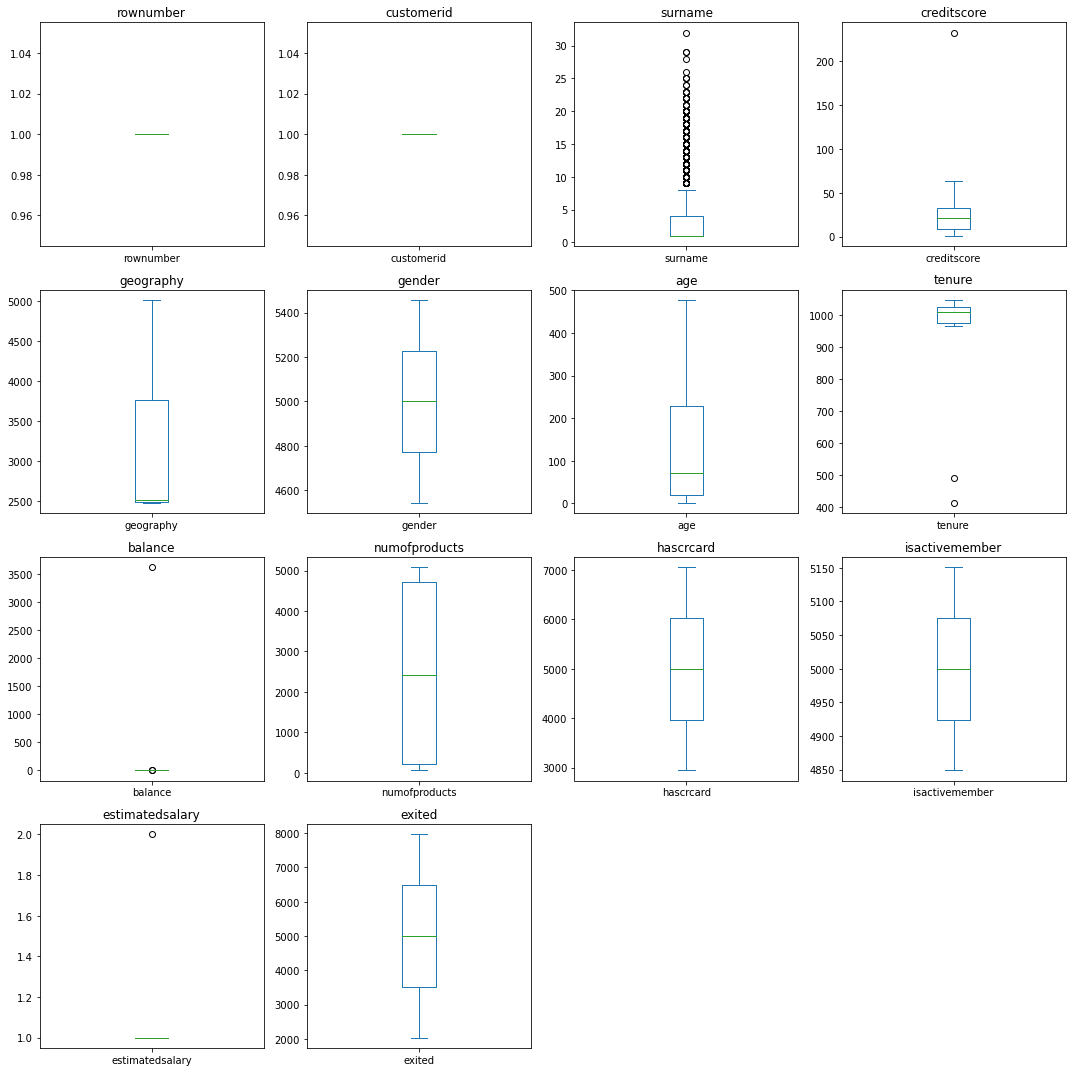

In [5]:
fig = plt.figure(figsize = (15, 15))
for i, col in enumerate(churn_df, 1):
    fig.add_subplot(4, 4, i, )
    churn_df[col].value_counts().plot(kind = 'box', ax = plt.gca())
    plt.title(col)
plt.tight_layout()
plt.show()

The box plots show that more columns have significant outliers than I anticipated. Keep in mind that by default, `matplotlib` used the whiskers to be 1.5 times the standard deviation away from the first and the third quartiles. Out of the box plots, we do not need to worry about columns with a few data types as it will be irrelevant to our research (`RowNumber`, `CustomerId`, `Surname`). This narrows down the outliers that we need to treat to four features: `CreditScore`, `Tenure`, `Balance`, and `EstimatedSalary`. We will look at histograms for all four colums.

Text(0.5, 1.0, '`estimatedsalary` histogram')

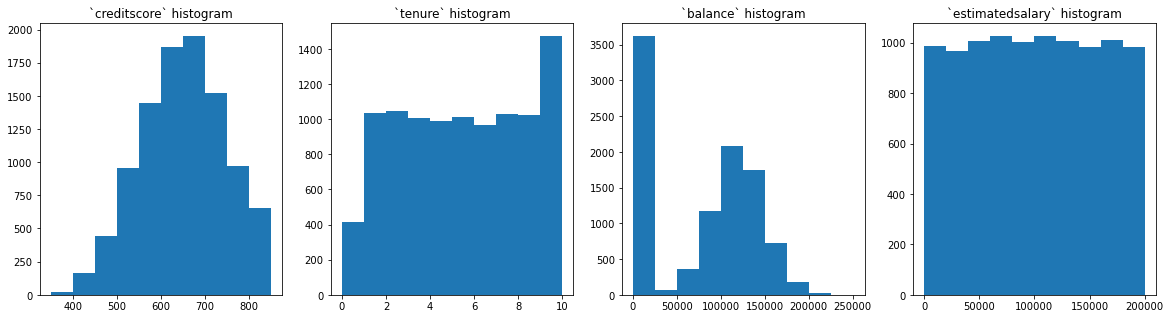

In [6]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 4, 1)
plt.hist(churn_df["creditscore"])
plt.title("`creditscore` histogram")

plt.subplot(1, 4, 2)
plt.hist(churn_df["tenure"])
plt.title("`tenure` histogram")

plt.subplot(1, 4, 3)
plt.hist(churn_df["balance"])
plt.title("`balance` histogram")

plt.subplot(1, 4, 4)
plt.hist(churn_df["estimatedsalary"])
plt.title("`estimatedsalary` histogram")

None of the four features above are in a normal distribution. Hence, I will transform the data using winsorization. I tried using the log transformation - however, I was keep getting an error as I was building a supervised model, as log transformation creates infinite scale. 

One thing that stands out from the histograms is `EstimatedSalary` histogram. Above in `describe()` method, it shows that the minimum value is 11.58. This seems like a clear error to me, as the 25 percentile number is 51002.11, and the standard deviation is 57510.492818. Therefore, for `EstimatedSalary`, I will use two-way winsorization in order to limit the highest and the lowest end of the value distribution. 

In [7]:
churn_df["tenure_winsorized"] = winsorize(churn_df["tenure"], (0.05, 0.05))
churn_df["credit_winsorized"] = winsorize(churn_df["creditscore"], (0.05, 0.05))
churn_df["balance_winsorized"] = winsorize(churn_df["balance"], (0.05, 0.05))
churn_df["salary_winsorized"] = winsorize(churn_df["estimatedsalary"], (0.05, 0.05))

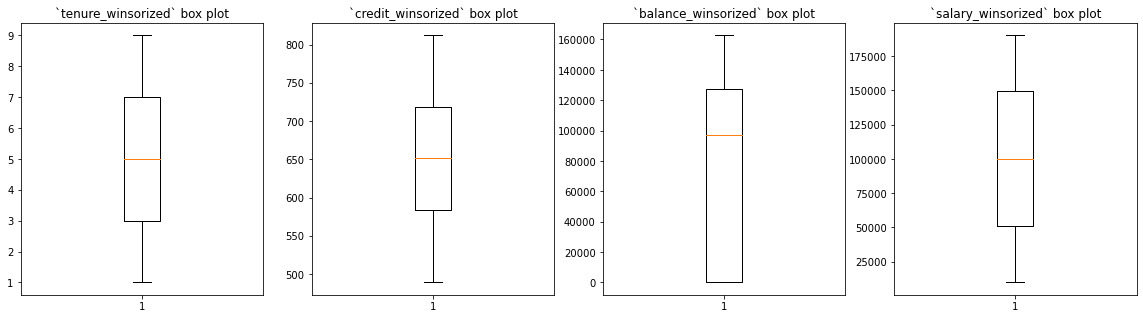

In [8]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 4, 1)
plt.boxplot(churn_df["tenure_winsorized"])
plt.title("`tenure_winsorized` box plot")

plt.subplot(1, 4, 2)
plt.boxplot(churn_df["credit_winsorized"])
plt.title("`credit_winsorized` box plot")

plt.subplot(1, 4, 3)
plt.boxplot(churn_df["balance_winsorized"])
plt.title("`balance_winsorized` box plot")

plt.subplot(1, 4, 4)
plt.boxplot(churn_df["salary_winsorized"])
plt.title("`salary_winsorized` box plot")

plt.show()

The result seems satisfactory. Let's review the features we have so far.

In [9]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rownumber           10000 non-null  int64  
 1   customerid          10000 non-null  int64  
 2   surname             10000 non-null  object 
 3   creditscore         10000 non-null  int64  
 4   geography           10000 non-null  object 
 5   gender              10000 non-null  object 
 6   age                 10000 non-null  int64  
 7   tenure              10000 non-null  int64  
 8   balance             10000 non-null  float64
 9   numofproducts       10000 non-null  int64  
 10  hascrcard           10000 non-null  int64  
 11  isactivemember      10000 non-null  int64  
 12  estimatedsalary     10000 non-null  float64
 13  exited              10000 non-null  int64  
 14  tenure_winsorized   10000 non-null  int64  
 15  credit_winsorized   10000 non-null  int64  
 16  balan

## Feature Engineering

Now that we have changed variable types and treated outliers, I will identify features that are meaningless to me. 

First of all, all `object` data type features can be eliminated. I assume that the last name of customers will be significant for churning. Also, we changed the variable types for `Gender` and `Geography`. 

Also, I do not need `CreditScore`, `Tenure`, `Balance`, `EstimatedSalary`, `creditscore_log` and `balance_log`, because I treated outliers.

Lastly, `RowNumber` and `CustomerId` will also be irrelevant for our research.

As for categorical features such as `HasCrCard`, `IsActiveMember`, `Geography`, and `Gender`, I will use the `get_dummy()` method to create its own column, so that we can get a clearer understanding.

In [10]:
cleaned_df = churn_df[['geography','gender', 'age', 'numofproducts', 'hascrcard', 'isactivemember', 
                     'tenure_winsorized', 'salary_winsorized', 'credit_winsorized', 'balance_winsorized', 'exited']]

unique_vals = {}
print("Unique values for each feature:\n")

for column in cleaned_df.columns:
    unique_vals[column] = cleaned_df[column].unique()
    print(len(unique_vals[column]), 'unique values of', column)

Unique values for each feature:

3 unique values of geography
2 unique values of gender
70 unique values of age
4 unique values of numofproducts
2 unique values of hascrcard
2 unique values of isactivemember
9 unique values of tenure_winsorized
8999 unique values of salary_winsorized
324 unique values of credit_winsorized
5882 unique values of balance_winsorized
2 unique values of exited


In [11]:
cleaned_df["hascrcard"] = pd.get_dummies(cleaned_df["hascrcard"], drop_first = True)
cleaned_df["isactivemember"] = pd.get_dummies(cleaned_df["isactivemember"], drop_first = True)
cleaned_df = pd.concat([cleaned_df, pd.get_dummies(cleaned_df["geography"], drop_first = False)], axis = 1)
cleaned_df = cleaned_df.drop(["geography"], axis = 1)
cleaned_df["ismale"] = pd.get_dummies(cleaned_df["gender"], drop_first = True)
cleaned_df = cleaned_df.drop(["gender"], axis=1)

cleaned_df.columns = cleaned_df.columns.str.lower()
print(cleaned_df.info())
cleaned_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 10000 non-null  int64  
 1   numofproducts       10000 non-null  int64  
 2   hascrcard           10000 non-null  uint8  
 3   isactivemember      10000 non-null  uint8  
 4   tenure_winsorized   10000 non-null  int64  
 5   salary_winsorized   10000 non-null  float64
 6   credit_winsorized   10000 non-null  int64  
 7   balance_winsorized  10000 non-null  float64
 8   exited              10000 non-null  int64  
 9   france              10000 non-null  uint8  
 10  germany             10000 non-null  uint8  
 11  spain               10000 non-null  uint8  
 12  ismale              10000 non-null  uint8  
dtypes: float64(2), int64(5), uint8(6)
memory usage: 605.6 KB
None


,age,numofproducts,hascrcard,isactivemember,tenure_winsorized,salary_winsorized,credit_winsorized,balance_winsorized,exited,france,germany,spain,ismale
0,42,1,1,1,2,101348.88,619,0.00,1,1,0,0,0
1,41,1,0,1,1,112542.58,608,83807.86,0,0,0,1,0
2,42,3,1,0,8,113931.57,502,159660.80,1,1,0,0,0
3,39,2,0,0,1,93826.63,699,0.00,0,1,0,0,0
4,43,1,1,1,2,79084.10,812,125510.82,0,0,0,1,0


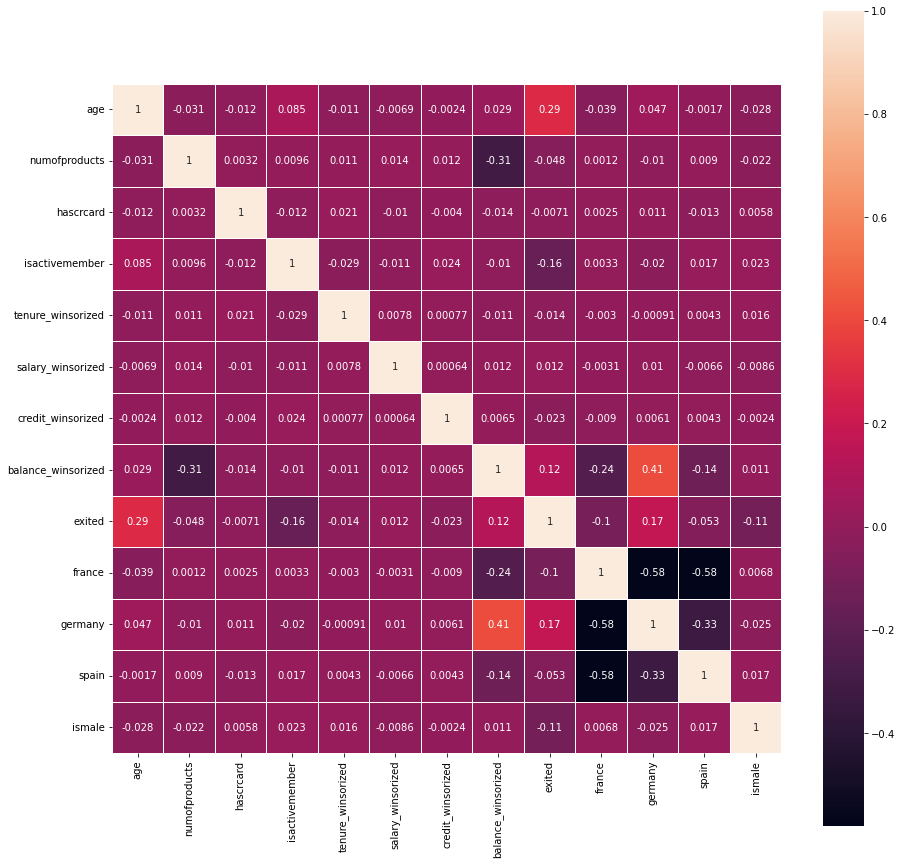

In [12]:
plt.figure(figsize = (15, 15))
sns.heatmap(cleaned_df.corr(), square = True, annot = True, linewidths = 0.5)
plt.show()

With the highest correlation coefficient to `Exited` is only 0.29, no one feature is strongly correlated to the `Exited` label. 

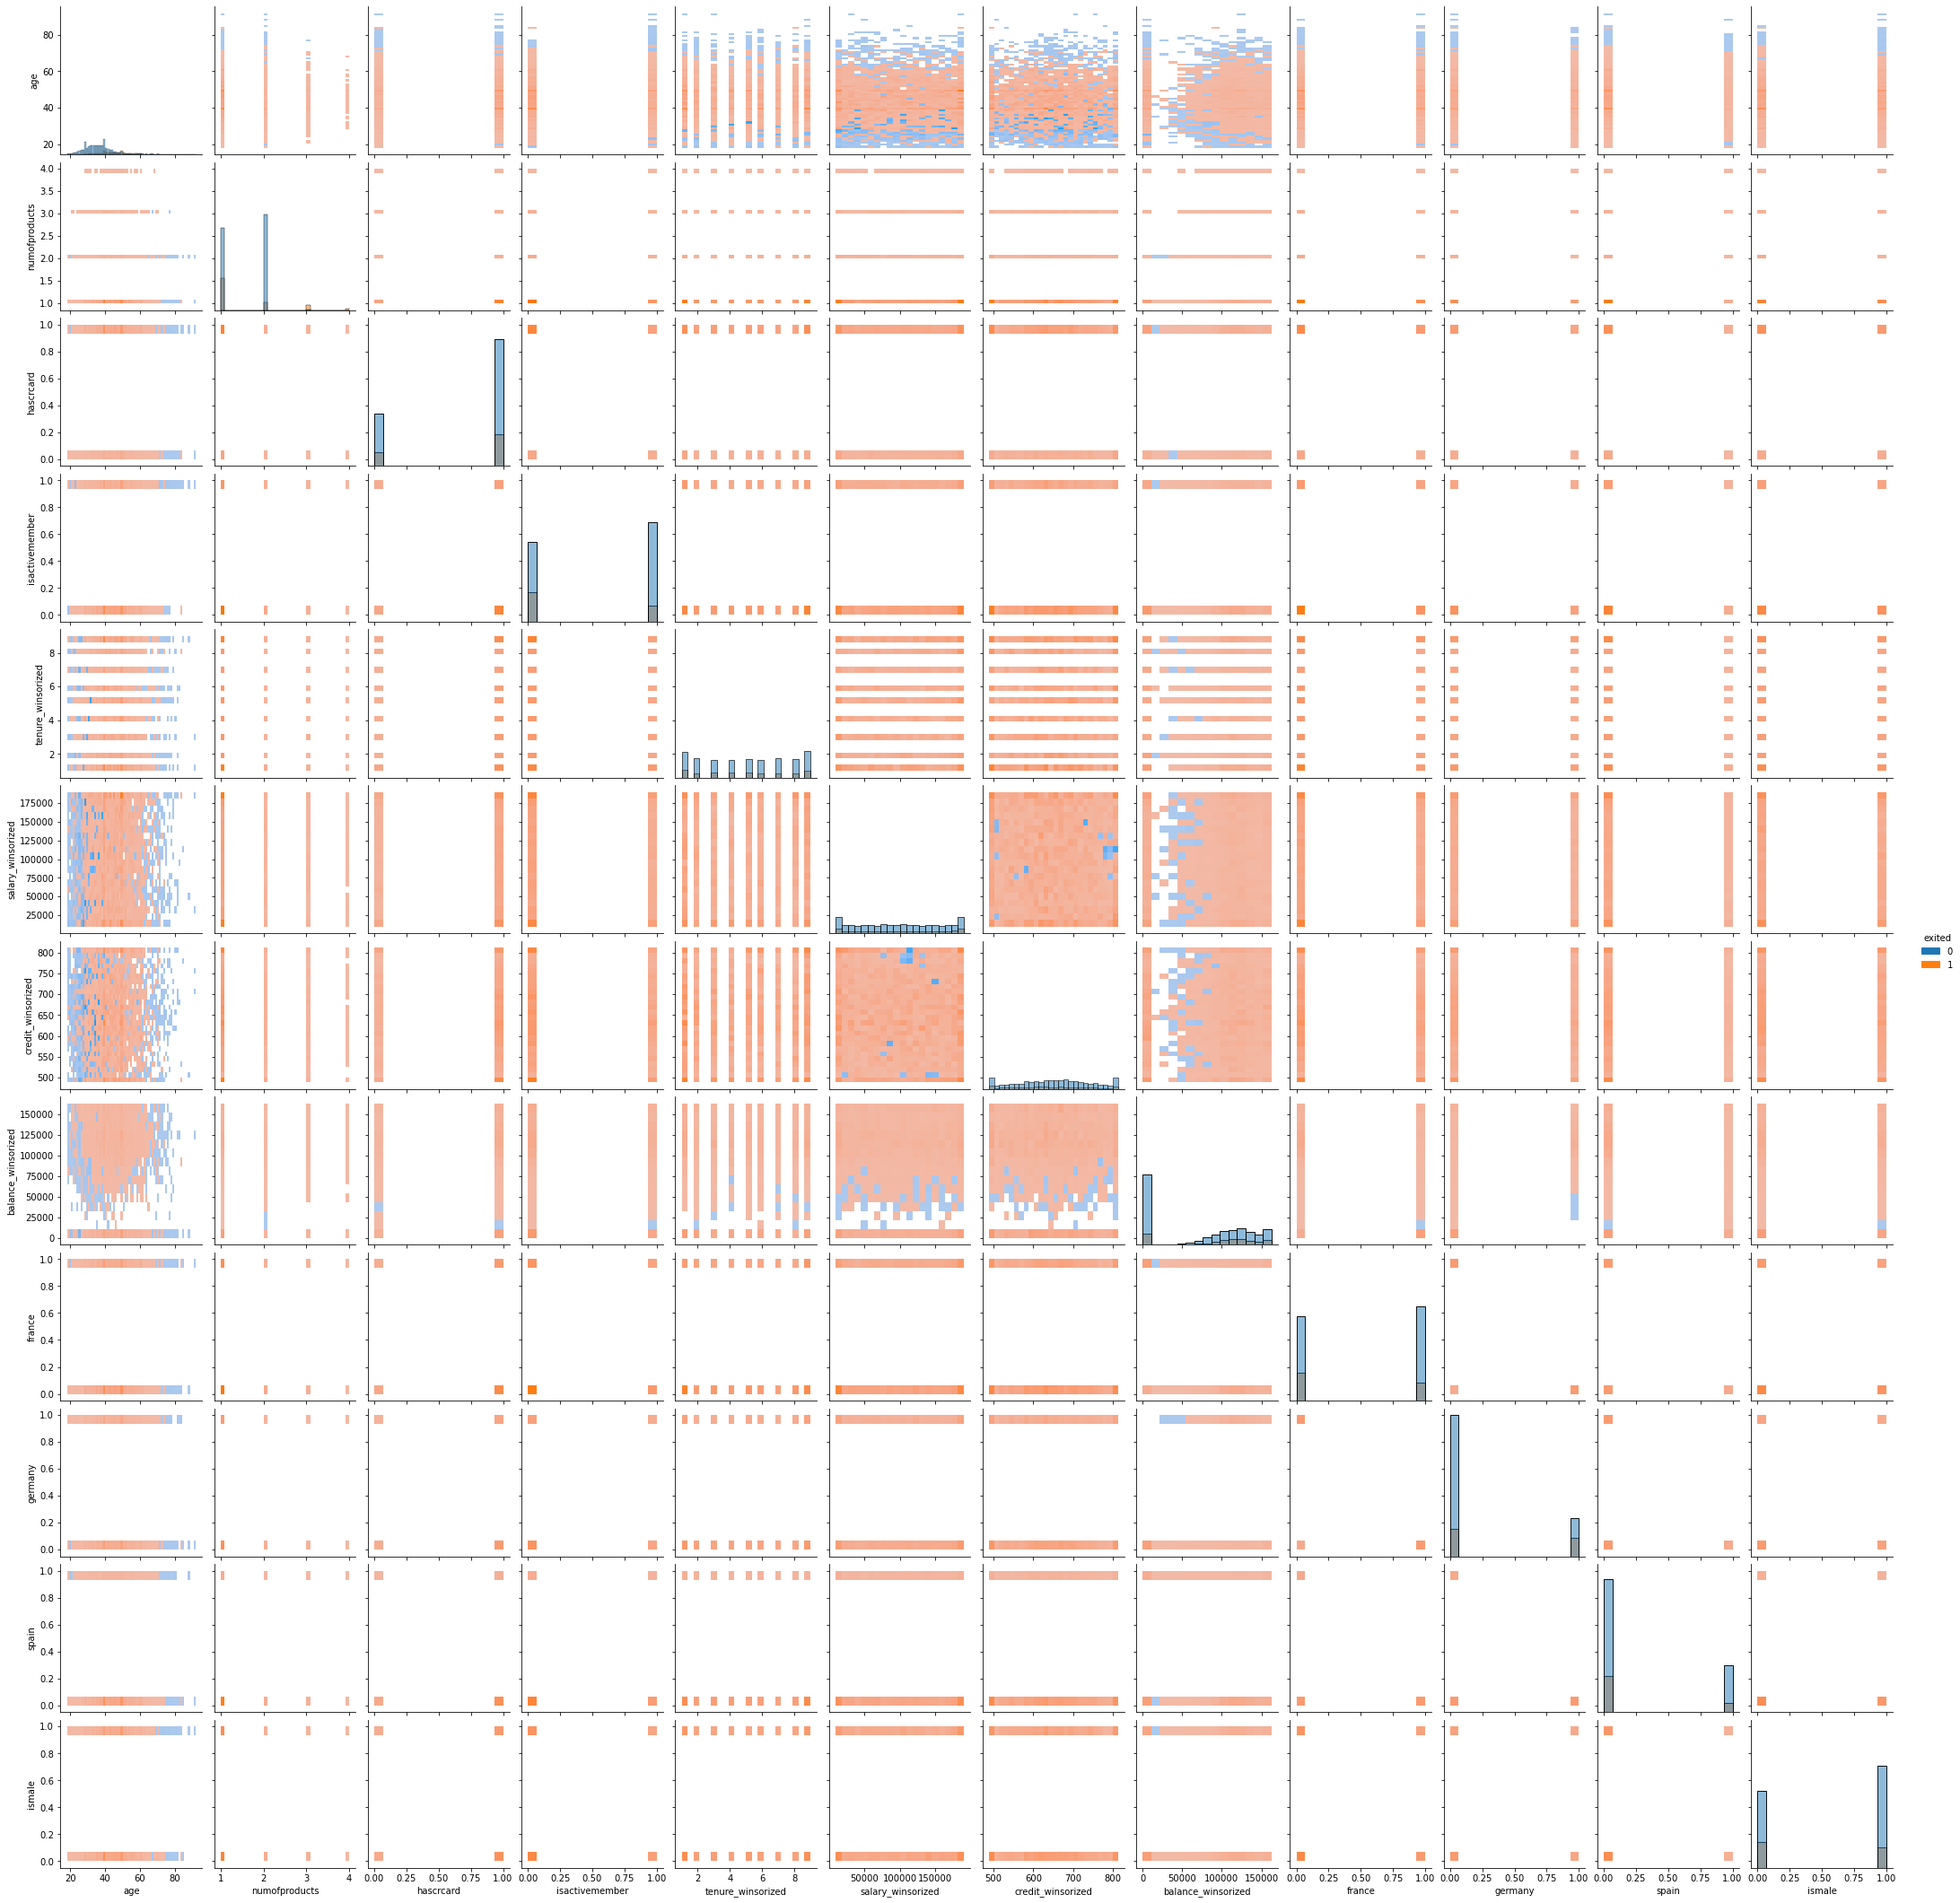

In [13]:
sns.pairplot(cleaned_df[['age', 'numofproducts', 'hascrcard', 'isactivemember', 'tenure_winsorized', 'salary_winsorized', 
                     'credit_winsorized', 'balance_winsorized', 'france', 'germany', 'spain', 'ismale', 'exited']], 
             hue = "exited", kind = "hist")
plt.show()

From the pair plots, I analyze that age and balance, credit, and salary interacted seems to show the trend that people in the middle age group tend to churn, whereas other age pair plots show that younger crowd was staying with the bank. I also see that balance interacting with salary and credit show younger crowd are churning. 

Based on the findings, I'll create interaction features between age and salary, age and balance, age and credit, balance and salary, and balance and credit.

In [14]:
cleaned_df["age_salary"] = cleaned_df["age"] * cleaned_df["salary_winsorized"]
cleaned_df["age_balance"] = cleaned_df["age"] * cleaned_df["balance_winsorized"]
cleaned_df["age_credit"] = cleaned_df["age"] * cleaned_df["credit_winsorized"]
cleaned_df["balance_salary"] = cleaned_df["balance_winsorized"] * cleaned_df["salary_winsorized"]
cleaned_df["balance_credit"] = cleaned_df["balance_winsorized"] * cleaned_df["credit_winsorized"]

cleaned_df = cleaned_df[['age', 'numofproducts', 'hascrcard', 'isactivemember', 'tenure_winsorized', 'salary_winsorized', 
             'credit_winsorized', 'balance_winsorized', 'france', 'germany', 'spain', 'ismale', 'age_salary', 
             'age_balance', 'age_credit', 'balance_salary', 'balance_credit', 'exited']]

In [15]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 10000 non-null  int64  
 1   numofproducts       10000 non-null  int64  
 2   hascrcard           10000 non-null  uint8  
 3   isactivemember      10000 non-null  uint8  
 4   tenure_winsorized   10000 non-null  int64  
 5   salary_winsorized   10000 non-null  float64
 6   credit_winsorized   10000 non-null  int64  
 7   balance_winsorized  10000 non-null  float64
 8   france              10000 non-null  uint8  
 9   germany             10000 non-null  uint8  
 10  spain               10000 non-null  uint8  
 11  ismale              10000 non-null  uint8  
 12  age_salary          10000 non-null  float64
 13  age_balance         10000 non-null  float64
 14  age_credit          10000 non-null  int64  
 15  balance_salary      10000 non-null  float64
 16  balan

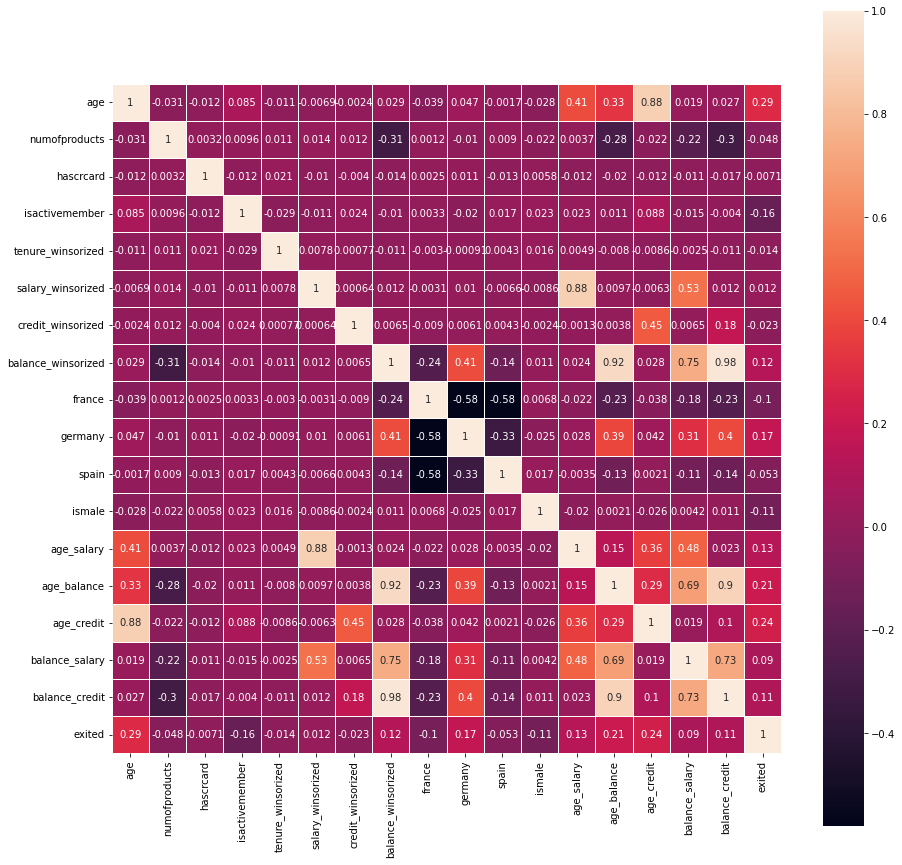

In [16]:
plt.figure(figsize = (15, 15))
sns.heatmap(cleaned_df.corr(), square = True, annot = True, linewidths = 0.5)
plt.show()

## Supervised Modeling

First, we need to create features and labels by defining them.

In [17]:
features = cleaned_df.drop(["exited"], axis = 1)
label = cleaned_df[["exited"]]

X_train, X_test, y_train, y_test = train_test_split(features, label, train_size = 0.7, random_state = 626)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 7000
The number of observations in test set is 3000


I decided to make the training dataset to be 70% and the test set to be 30% so that both dataset will have ample amount of samples to run the model. 

Next, I'll create many classification models, and within each model, I'll use the accuracy to compare the best parameter to use on the model.

### Logistic Regression

In [18]:
# With standard parameters:
lr = LogisticRegression(random_state = 626)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print('Logistic regression accuracy with standard parameters: {:.3f}'.format(lr_score))

# With Elastic Net penalty with L1 penalty at 50%:
lr = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, random_state = 626)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print('Logistic regression accuracy with Elastic Net penalty: {:.3f}'.format(lr_score))

# With L1 penalty and max iteration at 1000:
lr = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter = 1000, random_state = 626)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print('Logistic regression accuracy with L1 penalty and 1000 maximum iteration: {:.3f}'.format(lr_score))

# With L1 penalty and `liblinear` solver:
lr = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = 626)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
lr_prediction = lr.predict(X_test)
print('Logistic regression accuracy with L1 penalty and liblinear solver: {:.3f}'.format(lr_score))


Logistic regression accuracy with standard parameters: 0.787
Logistic regression accuracy with Elastic Net penalty: 0.790
Logistic regression accuracy with L1 penalty and 1000 maximum iteration: 0.790
Logistic regression accuracy with L1 penalty and liblinear solver: 0.813


Out of the logistic regression models, L1 penalty seems to be the most accurate. 

### KNN 

In [19]:
# With standard parameters (K = 5):
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print('KNN accuracy with standard parameters: {:.3f}'.format(knn_score))

# With K = 9:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print('KNN accuracy with K = 9: {:.3f}'.format(knn_score))

# With K = 7 and weight = 'distance':
knn = KNeighborsClassifier(n_neighbors = 7, weights = 'distance')
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print('KNN accuracy with K = 7 and weight = distance: {:.3f}'.format(knn_score))

# With K = 11 and p = 1:
knn = KNeighborsClassifier(n_neighbors = 11, p = 1)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
knn_prediction = knn.predict(X_test)
print('KNN accuracy with K = 11 and p = 1: {:.3f}'.format(knn_score))


KNN accuracy with standard parameters: 0.750
KNN accuracy with K = 9: 0.776
KNN accuracy with K = 7 and weight = distance: 0.743
KNN accuracy with K = 11 and p = 1: 0.777


For KNN, The higher K value is, the better accuracy we received. For the sake of this model, we will use KNN with K = 11 and penalty as L1.

### Decision Tree

In [20]:
# Decision tree with criterion = entropy:
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 626)
dt.fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
print('Decision tree with criterion = entropy: {:.3f}'.format(dt_score))

# Decision tree with max_features = auto:
dt = DecisionTreeClassifier(max_features = 'auto', random_state = 626)
dt.fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
dt_prediction = dt.predict (X_test)
print('Decision tree with max_features = auto: {:.3f}'.format(dt_score))

# Decision tree with standard parameters:
dt = DecisionTreeClassifier(random_state = 626)
dt.fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
print('Decision tree with standard parameters: {:.3f}'.format(dt_score))

Decision tree with criterion = entropy: 0.783
Decision tree with max_features = auto: 0.764
Decision tree with standard parameters: 0.791


The decision tree performed best with standard parameters. 

###  Random Forest

In [21]:
# Random forest with standard parameters:
rf = RandomForestClassifier(random_state = 626)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print('Random forest with standard parameters: {:.3f}'.format(rf_score))

# Random forest with number of trees in the forest set to 1000 and out of bag samples are used:
rf = RandomForestClassifier(n_estimators = 1000, oob_score = True, random_state = 626)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print('Random forest with number of trees in the forest set to 1000 and out of bag samples used: {:.3f}'.format(rf_score))

# Random forest with number of trees in the forest set to 1000:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 626)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
rf_prediction = rf.predict (X_test)
print('Random forest with number of trees in the forest set to 1000: {:.3f}'.format(rf_score))

Random forest with standard parameters: 0.851
Random forest with number of trees in the forest set to 1000 and out of bag samples used: 0.854
Random forest with number of trees in the forest set to 1000: 0.854


Random Forest, by far, has the best accuracy, especially with the number of trees increased to 1000.

### Support Vector Machine

In [22]:
# SVM with standard parameters:
svm = LinearSVC(random_state = 626)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
print('SVC with standard parameters: {:.3f}'.format(svm_score))

# SVM with hinge loss:
svm = LinearSVC(loss = 'hinge', random_state = 626)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
print('SVC with loss hinge: {:.3f}'.format(svm_score))

# SVM with L1 penalty and balanced class weight:
svm = LinearSVC(penalty = 'l1', dual = False, class_weight = 'balanced', random_state = 626)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
print('SVC with L1 penalty and balanced class weight: {:.3f}'.format(svm_score))

# SVM with L1 penalty:
svm = LinearSVC(penalty = 'l1', dual = False, random_state = 626)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
svm_prediction = svm.predict(X_test)
print('SVC with L1 penalty: {:.3f}'.format(svm_score))

SVC with standard parameters: 0.212
SVC with loss hinge: 0.212
SVC with L1 penalty and balanced class weight: 0.716
SVC with L1 penalty: 0.809


SVC performed best with L1 penalty as well. 

### Gradient Boost

In [23]:
# Gradient boost with exponential loss:
gb = ensemble.GradientBoostingClassifier(loss = 'exponential', random_state = 626)
gb.fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)
print('Gradient boost with exponential loss: {:.3f}'.format(gb_score))

# Gradient boost with 1000 n-estimators:
gb = ensemble.GradientBoostingClassifier(n_estimators = 1000, random_state = 626)
gb.fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)
print('Gradient boost with 1000 n-estimators: {:.3f}'.format(gb_score))

# Gradient boost with max depth = 10:
gb = ensemble.GradientBoostingClassifier(max_depth = 10, random_state = 626)
gb.fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)
print('Gradient boost with max depth = 10: {:.3f}'.format(gb_score))

# Gradient boost with standard parameters:
gb = ensemble.GradientBoostingClassifier(random_state = 626)
gb.fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)
gb_prediction = gb.predict(X_test)
print('Gradient boost with standard parameters: {:.3f}'.format(gb_score))

Gradient boost with exponential loss: 0.858
Gradient boost with 1000 n-estimators: 0.850
Gradient boost with max depth = 10: 0.851
Gradient boost with standard parameters: 0.859


Gradient boost performed best with the standard parameters. 

Next, we will utilize the best performing parameters and compare other evaluation criteria.

In [24]:
def plot_confusion_matrix(cm, classes, normalize, title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = 'center', verticalalignment = 'center',
             color = 'white' if  cm[i, j] > thresh else 'black')
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

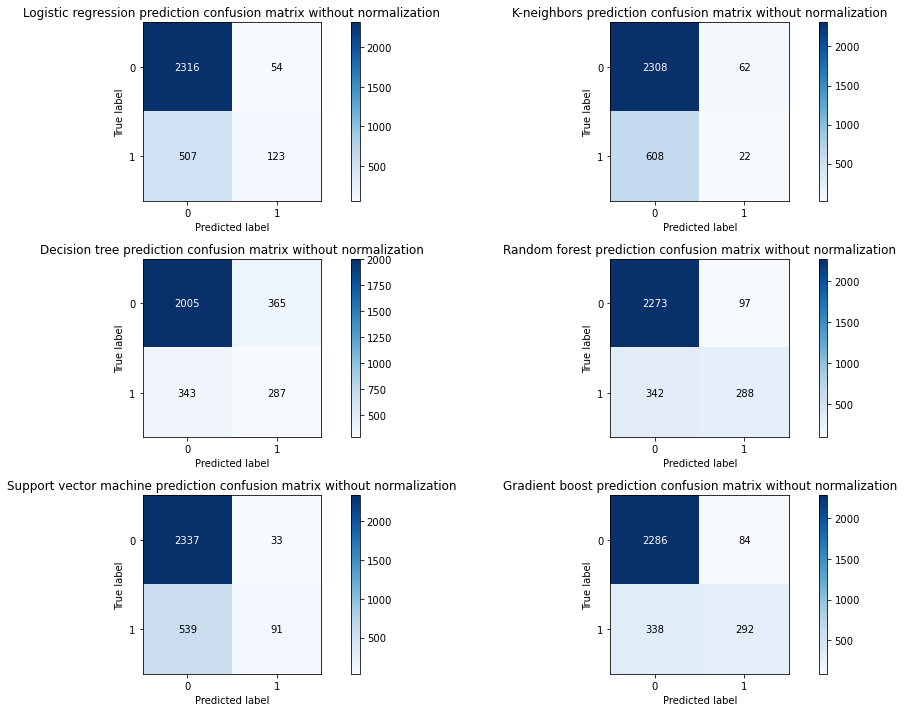

In [25]:
cm_lr = confusion_matrix(y_test, lr_prediction)
cm_knn = confusion_matrix(y_test, knn_prediction)
cm_dt = confusion_matrix(y_test, dt_prediction)
cm_rf = confusion_matrix(y_test, rf_prediction)
cm_svm = confusion_matrix(y_test, svm_prediction)
cm_gb = confusion_matrix(y_test, gb_prediction)

plt.figure(figsize = (15, 10))
plt.subplot(3, 2, 1)
plot_confusion_matrix(cm_lr, [0, 1], False)
plt.title("Logistic regression prediction confusion matrix without normalization")
plt.subplot(3, 2, 2)
plot_confusion_matrix(cm_knn, [0, 1], False)
plt.title("K-neighbors prediction confusion matrix without normalization")
plt.subplot(3, 2, 3)
plot_confusion_matrix(cm_dt, [0, 1], False)
plt.title("Decision tree prediction confusion matrix without normalization")
plt.subplot(3, 2, 4)
plot_confusion_matrix(cm_rf, [0, 1], False)
plt.title("Random forest prediction confusion matrix without normalization")
plt.subplot(3, 2, 5)
plot_confusion_matrix(cm_svm, [0, 1], False)
plt.title("Support vector machine prediction confusion matrix without normalization")
plt.subplot(3, 2, 6)
plot_confusion_matrix(cm_gb, [0, 1], False)
plt.title("Gradient boost prediction confusion matrix without normalization")

plt.tight_layout()
plt.show()

In [26]:
lr_report = classification_report(y_test, lr_prediction, target_names = ['Stayed', 'Exited'])
print("\n---------------Logistic Regression-------------------")
print(lr_report)

knn_report = classification_report(y_test, knn_prediction, target_names = ['Stayed', 'Exited'])
print("\n-------------------------KNN-------------------------")
print(knn_report)

dt_report = classification_report(y_test, dt_prediction, target_names = ['Stayed', 'Exited'])
print("\n--------------------Decision Tree--------------------")
print(dt_report)

rf_report = classification_report(y_test, rf_prediction, target_names = ['Stayed', 'Exited'])
print("\n--------------------Random Forest--------------------")
print(rf_report)

svm_report = classification_report(y_test, svm_prediction, target_names = ['Stayed', 'Exited'])
print("\n----------------Support Vector Machine----------------")
print(svm_report)

gb_report = classification_report(y_test, gb_prediction, target_names = ['Stayed', 'Exited'])
print("\n--------------------Gradient Boost--------------------")
print(gb_report)


---------------Logistic Regression-------------------
              precision    recall  f1-score   support

      Stayed       0.82      0.98      0.89      2370
      Exited       0.69      0.20      0.30       630

    accuracy                           0.81      3000
   macro avg       0.76      0.59      0.60      3000
weighted avg       0.79      0.81      0.77      3000


-------------------------KNN-------------------------
              precision    recall  f1-score   support

      Stayed       0.79      0.97      0.87      2370
      Exited       0.26      0.03      0.06       630

    accuracy                           0.78      3000
   macro avg       0.53      0.50      0.47      3000
weighted avg       0.68      0.78      0.70      3000


--------------------Decision Tree--------------------
              precision    recall  f1-score   support

      Stayed       0.85      0.85      0.85      2370
      Exited       0.44      0.46      0.45       630

    accuracy     

The above report show that KNN is clearly not a good model for this dataset, with both precision and recall values for `exited` being the lowest. 

Also, all of the models favored precision over recall for `exited`, except for the decision tree model. However, for `stayed`, recall values are higher, again except for the decision tree model. 

With all precision, recall, and accuracy combined, I assess that **gradient boost in this case is the best supervised model**.

We will now look at evaluation metrics for both training set (r-squared), and test set (MAE, MSE, and RMSE).

In [41]:
table = BeautifulTable()
table.rows.append(["Logistic \nRegression", 
                   lr.score(X_train, y_train), 
                   mean_absolute_error(y_test, lr_prediction), 
                   np.mean(mse(y_test, lr_prediction)), 
                   np.mean(rmse(y_test, lr_prediction)), 
                   np.mean(cross_val_score(lr, X_train, y_train, cv=5))])

table.rows.append(["KNN (K = 11)", 
                   knn.score(X_train, y_train), 
                   mean_absolute_error(y_test, knn_prediction), 
                   colored(np.mean(mse(y_test, knn_prediction)), 'green'), 
                   colored(np.mean(rmse(y_test, knn_prediction)), 'green'), 
                   np.mean(cross_val_score(knn, X_train, y_train, cv=5))])

table.rows.append(["Decision Tree", 
                   colored(dt.score(X_train, y_train),'blue'), 
                   mean_absolute_error(y_test, dt_prediction), 
                   np.mean(mse(y_test, dt_prediction)), 
                   np.mean(rmse(y_test, dt_prediction)), 
                   np.mean(cross_val_score(dt, X_train, y_train, cv=5))])

table.rows.append(["Random Forest", 
                   colored(rf.score(X_train, y_train), 'blue'), 
                   mean_absolute_error(y_test, rf_prediction), 
                   np.mean(mse(y_test, rf_prediction)), 
                   np.mean(rmse(y_test, rf_prediction)), 
                   np.mean(cross_val_score(rf, X_train, y_train, cv=5))])

table.rows.append(["Support Vector \nMachine", 
                   svm.score(X_train, y_train), 
                   mean_absolute_error(y_test, svm_prediction), 
                   np.mean(mse(y_test, svm_prediction)), 
                   np.mean(rmse(y_test, svm_prediction)), 
                   np.mean(cross_val_score(svm, X_train, y_train, cv=5))])

table.rows.append(["Gradient Boost", 
                   colored(gb.score(X_train, y_train), 'green'), 
                   colored(mean_absolute_error(y_test, gb_prediction), 'green'), 
                   np.mean(mse(y_test, gb_prediction)), 
                   np.mean(rmse(y_test, gb_prediction)), 
                   colored(np.mean(cross_val_score(gb, X_train, y_train, cv=5)), 'green')])

table.columns.header = ["Supervised \nLearning \ntechnique", "Training set R-squared", "MAE", 
                       "MSE", "RMSE", "5-fold Mean Cross Validation"]
print(table)

+----------+-------------+------------+---------+------------+-----------------+
| Supervis | Training se |    MAE     |   MSE   |    RMSE    | 5-fold Mean Cro |
|   ed     | t R-squared |            |         |            |  ss Validation  |
| Learning |             |            |         |            |                 |
|          |             |            |         |            |                 |
| techniqu |             |            |         |            |                 |
|    e     |             |            |         |            |                 |
+----------+-------------+------------+---------+------------+-----------------+
| Logistic |    0.812    |   0.187    |  0.244  |   0.484    |      0.811      |
|          |             |            |         |            |                 |
| Regressi |             |            |         |            |                 |
|    on    |             |            |         |            |                 |
+----------+-------------+--

The best training set performance was executed by the decision tree and the random forest models with r-squared number being 1. However, 1 poses a threat to overfit. The next highest value was achieved by Gradient Boost. 

With the error evaluation metrics, the gradient boost model achieved the lowest MAE value, while KNN model achieved the lowest MSE and RMSE values.

The 5-fold mean cross validation shows that, again, the gradient boost model performed the best. 

With all of the above considered, **the best supervised model to predict churning for this specific case is gradient boost**. 

I do not see overfitting as a problem with the gradient boost model, because the test set r-squared is 0.86 and the training set r-squared is 0.88, which are within the similar range. 

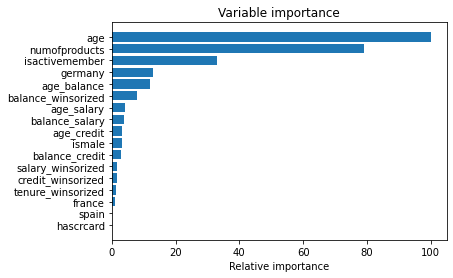

In [28]:
feature_importance = gb.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative importance")
plt.title("Variable importance")
plt.show()

The above histogram shows that the most important features are age, number of products, and active member status.

One significance that shows in this model is that German customers tend to churn with this bank. Further studies on whether the country of residency interacts with other variable is necessary to determine exactly what the relationship is. 

## Unsupervised modeling

First, I will reduce the dimensionality using PCA. This will help us see the data in 2-dimension.
### PCA Dimensionality Reduction

In [29]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(cleaned_df)
scaled_feat = scaler.fit_transform(features)
scaled_label = scaler.fit_transform(label)
# Now scaled_df is a numpy array, not a dataframe.

In [30]:
pca = PCA(2)
pca_result = pca.fit_transform(scaled_feat)

### K Means Cluster

I'll run an elbow method to find out the best number of clusters for the model.

In [31]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(features)
    distortions.append(kmeanModel.inertia_)

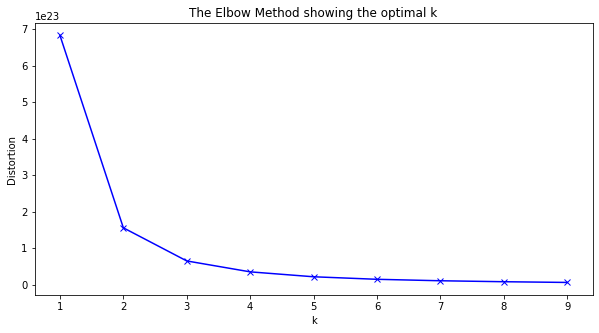

In [32]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The "elbow" occurs at 3, which we will make k equal to.

Now, we will run a K-means clustering model.

In [33]:
kmeans = KMeans(n_clusters = 3)
kmeans_results = kmeans.fit(scaled_feat)
kmeans_pred = kmeans.fit_predict(scaled_feat)

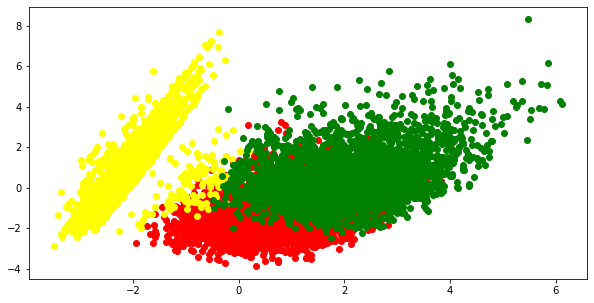

In [34]:
filtered_label0 = pca_result[kmeans_pred == 0]
filtered_label1 = pca_result[kmeans_pred == 1]
filtered_label2 = pca_result[kmeans_pred == 2]

plt.figure(figsize=(10,5))

plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color = 'red')
plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color = 'yellow')
plt.scatter(filtered_label2[:, 0], filtered_label2[:, 1], color = 'green')

plt.show()

The clustering, when applied to the data that we applied PCA earlier, show that the clustering is somewhat clear, but not extremely clear.

### Agglomerative Hierarchical clustering

For the hierarchical clustering, I'll use the silhouette score to identify the best number of clusters to apply.

In [35]:
agg_2 = metrics.silhouette_score(cleaned_df, AgglomerativeClustering(n_clusters = 2).fit_predict(pca_result))
agg_3 = metrics.silhouette_score(cleaned_df, AgglomerativeClustering(n_clusters = 3).fit_predict(pca_result))
agg_4 = metrics.silhouette_score(cleaned_df, AgglomerativeClustering(n_clusters = 4).fit_predict(pca_result))
agg_5 = metrics.silhouette_score(cleaned_df, AgglomerativeClustering(n_clusters = 5).fit_predict(pca_result))

print("The silhouette score for n_cluster = 2: ", agg_2)
print("The silhouette score for n_cluster = 3: ", agg_3)
print("The silhouette score for n_cluster = 4: ", agg_4)
print("The silhouette score for n_cluster = 5: ", agg_5)

The silhouette score for n_cluster = 2:  0.44876140224773625
The silhouette score for n_cluster = 3:  0.32769105360894585
The silhouette score for n_cluster = 4:  -0.05085855612584264
The silhouette score for n_cluster = 5:  -0.08550162096798776


The silhouette score indicates that the model fits best when n_cluster is 2. 

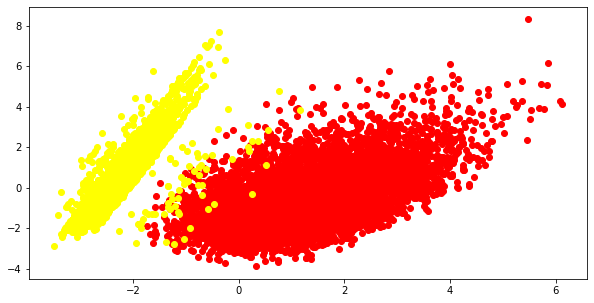

In [36]:
agg = AgglomerativeClustering(n_clusters = 2)
agg_pred = agg.fit_predict(scaled_feat)

filtered_label0 = pca_result[agg_pred == 0]
filtered_label1 = pca_result[agg_pred == 1]

plt.figure(figsize=(10,5))

plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color = 'red')
plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color = 'yellow')

plt.show()

Again, when we visualize the Agglomerative clustering through pca-reduced graphic, the technique clustered the data well, but there are room for improvement.

### Gaussian Mixture Models

For Gaussian Mixture Models, I will choose the number of clusters by comparing BIC and AIC numbers. 

In [37]:
n_range = range(2, 13)

bic_score = []
aic_score = []

for n in n_range:
    gm = GaussianMixture(n_components = n, random_state = 626)
    gm.fit(pca_result)
    bic_score.append(gm.bic(pca_result))
    aic_score.append(gm.aic(pca_result))

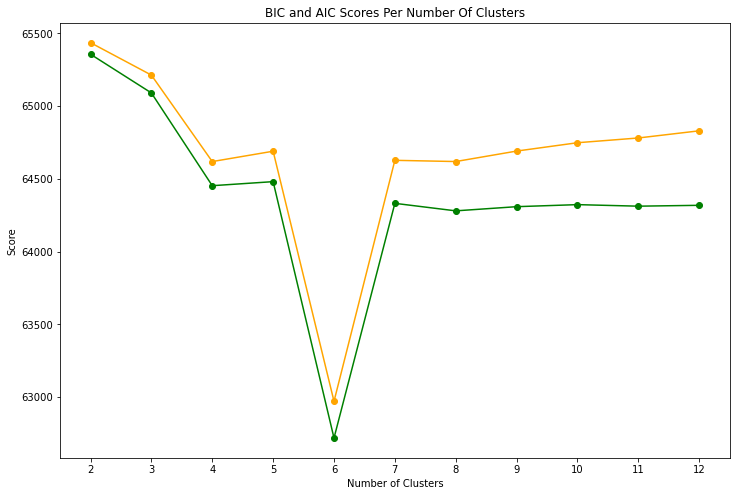

In [38]:
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')
plt.show()

Both BIC and AIC scores show that 6 clusters are the optimal number for the Gaussian Mixture Model. 

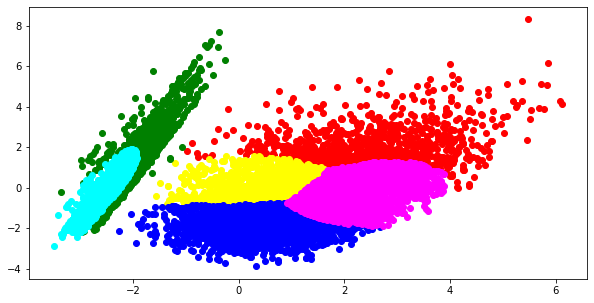

In [39]:
gm = GaussianMixture(n_components = 6)
gm_pred = gm.fit_predict(pca_result)

filtered_label0 = pca_result[gm_pred == 0]
filtered_label1 = pca_result[gm_pred == 1]
filtered_label2 = pca_result[gm_pred == 2]
filtered_label3 = pca_result[gm_pred == 3]
filtered_label4 = pca_result[gm_pred == 4]
filtered_label5 = pca_result[gm_pred == 5]

plt.figure(figsize=(10,5))

plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color = 'red')
plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color = 'yellow')
plt.scatter(filtered_label2[:, 0], filtered_label2[:, 1], color = 'blue')
plt.scatter(filtered_label3[:, 0], filtered_label3[:, 1], color = 'green')
plt.scatter(filtered_label4[:, 0], filtered_label4[:, 1], color = 'aqua')
plt.scatter(filtered_label5[:, 0], filtered_label5[:, 1], color = 'magenta')

plt.show()

With the Gaussian Mixture model technique with 6 clusters, the divide between each clusters seem more defined than the others. 

Next, we will use ARI and silhoutte coefficient to compare the three clustering techniques we showed.

## Comparing clusters with evaluation techniques

In [40]:
table = BeautifulTable()
table.rows.append(["K-Mean", 
                   metrics.adjusted_rand_score(cleaned_df['exited'], kmeans_pred), 
                   metrics.silhouette_score(cleaned_df, kmeans_pred)])
table.rows.append(["Agglomerative", 
                   metrics.adjusted_rand_score(cleaned_df['exited'], agg_pred), 
                   metrics.silhouette_score(cleaned_df, agg_pred)])
table.rows.append(["Gaussian Mixture", 
                   metrics.adjusted_rand_score(cleaned_df['exited'], gm_pred), 
                   metrics.silhouette_score(cleaned_df, gm_pred)])
table.columns.header = ["Clustering technique", "Adjusted Rand Index", "Silhouette Coefficient"]
print(table)

+----------------------+---------------------+------------------------+
| Clustering technique | Adjusted Rand Index | Silhouette Coefficient |
+----------------------+---------------------+------------------------+
|        K-Mean        |        0.013        |          0.49          |
+----------------------+---------------------+------------------------+
|    Agglomerative     |        -0.02        |         0.449          |
+----------------------+---------------------+------------------------+
|   Gaussian Mixture   |        0.032        |         0.023          |
+----------------------+---------------------+------------------------+


Using Adjusted Rand Index, Gaussian Mixture Model performed best in clustering, although the value is extremely small. Small ARI indicates that the clustering is closer to random than explained. 

On the other hand, **Silhouette coefficient shows that K-means clustering can explain about 50% of the fit**. 

Both numbers show that there is room for improvement, and **supervised learning models overall performed significantly better**.

# Conclusion

After running both supervised modeling and unsupervised clustering, I conclude that supervised modeling consistently provide a better learning model. I recommend, when label is available, using supervised modeling method.

This particular dataset performed best with the gradient boost model, and the model did not show an overfitting symptom. 

The next step to this analysis is to reduce the number of features based on the feature importance and correlation coefficient numbers, and performing the analysis on the new features.